In [18]:
from generate_ftw_rom import get_ftws
from generate_waveform_rom import get_waveform_rom
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.fftpack import fft

clock_frequency = 1e8
sampling_frequency = 40000
pwm_frequency = clock_frequency
phase_update_freq = clock_frequency
phase_bits = 48
address_bits = 13
sample_bits = 11
amplitude = 0.4

ftws = get_ftws(phase_bits, pwm_frequency)
waveform_rom = get_waveform_rom(address_bits, sample_bits)

In [19]:
# uses global params
def to_signed(value, bits):
    if value >= 2**(bits-1):
        return value - 2**bits
    return value

def dds_gen_output_2(note_number, sampling_frequency, total_time):
    phase_register = 0
    ftw = ftws[note_number]
    
    phase_updates_per_sample = int(phase_update_freq/sampling_frequency)
    total_samples = int(total_time*phase_update_freq)
    phase_values = ftw*phase_updates_per_sample*np.arange(0, total_samples, 1).astype(float)
    phase_values -= np.remainder(phase_values, 2**(phase_bits-address_bits))
    phase_values *= 2*np.pi/2**phase_bits
    ys = np.round(amplitude*2**(sample_bits-1)*np.sin(phase_values))

    ts = np.arange(0, total_time, 1/sampling_frequency)
    lmin = min(len(ts), len(ys))
    return ts[:lmin], ys[:lmin]

In [20]:
def dds_generate_output(note_number, sampling_frequency, total_time):
    phase_register = 0
    ftw = ftws[note_number]
    
    values = []
    phase_updates_per_sample = int(phase_update_freq/sampling_frequency)
    total_steps = int(total_time*phase_update_freq)
    for i in range(0, total_steps):
        if i % phase_updates_per_sample == 0:
            address = phase_register // 2 ** (phase_bits-address_bits)
            values.append(to_signed(waveform_rom[address], sample_bits))
        phase_register = (phase_register + ftw) % 2**phase_bits

    ts = np.arange(0, total_time, 1/sampling_frequency)
    lmin = min(len(ts), len(values))
    return ts[:lmin], values[:lmin]

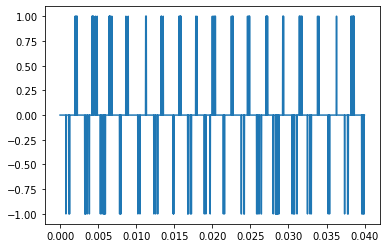

In [4]:
ts, ys = dds_gen_output_2(69, 40000, 0.04)
ts2, ys2 = dds_generate_output(69, 40000, 0.04)
plt.plot(ts2, ys2-ys)
    

In [21]:
def note_number_to_freq(note_number):
    s = 2**(1/12)
    return 440 * s**(note_number-69)

def get_dds_snr(note_number):
    print("Calculating SNR of note", note_number)
    freq = note_number_to_freq(note_number)
    periods_in_max_time = round(0.2*freq)
    total_time = max(15/freq, periods_in_max_time/freq)
    ts, ys = dds_gen_output_2(note_number, sampling_frequency, 0.1)
    no_dds = 0.4 * np.sin(2*np.pi*freq * ts) * 2**(sample_bits-1)
    dds_error = ys - no_dds
    signal_power = np.sum(no_dds**2)/len(no_dds)
    error_power = np.sum(dds_error ** 2)/len(dds_error)
    return signal_power/error_power

In [22]:
snrs = [get_dds_snr(i) for i in range(0, 128)]

Calculating SNR of note 0
Calculating SNR of note 1
Calculating SNR of note 2
Calculating SNR of note 3
Calculating SNR of note 4
Calculating SNR of note 5
Calculating SNR of note 6
Calculating SNR of note 7
Calculating SNR of note 8
Calculating SNR of note 9
Calculating SNR of note 10
Calculating SNR of note 11
Calculating SNR of note 12
Calculating SNR of note 13
Calculating SNR of note 14
Calculating SNR of note 15
Calculating SNR of note 16
Calculating SNR of note 17
Calculating SNR of note 18
Calculating SNR of note 19
Calculating SNR of note 20
Calculating SNR of note 21
Calculating SNR of note 22
Calculating SNR of note 23
Calculating SNR of note 24
Calculating SNR of note 25
Calculating SNR of note 26
Calculating SNR of note 27
Calculating SNR of note 28
Calculating SNR of note 29
Calculating SNR of note 30
Calculating SNR of note 31
Calculating SNR of note 32
Calculating SNR of note 33
Calculating SNR of note 34
Calculating SNR of note 35
Calculating SNR of note 36
Calculating

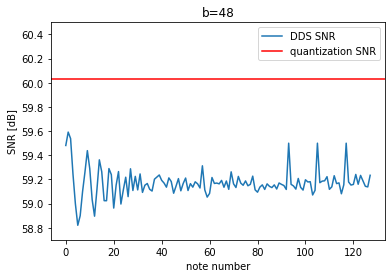

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [30]:
fig = plt.figure()
ax1 = fig.add_subplot()
ax1.set_ylabel('SNR [dB]')
ax1.set_xlabel('note number')
ax1.set_title('b=48')
plt.plot(list(range(0, len(snrs))), 10 * np.log10(snrs))
error_power = (2/2**sample_bits)**2/12
signal_power = (amplitude)**2/2
plt.axhline(10*np.log10(signal_power/error_power), color='r')
plt.ylim(58.7,60.5)
plt.legend(('DDS SNR', 'quantization SNR'))
plt.show()
fig.savefig('dds_snr.eps')

In [8]:
note_number = 120
freq = note_number_to_freq(note_number)
total_time = 0.2
ts, dds_signal = dds_gen_output_2(note_number, sampling_frequency, total_time)
no_dds = 0.4 * np.sin(2*np.pi*freq * ts) * 2**(sample_bits-1)
#filtered_signal = get_filtered_signal(dds_signal, sampling_frequency, 21000)



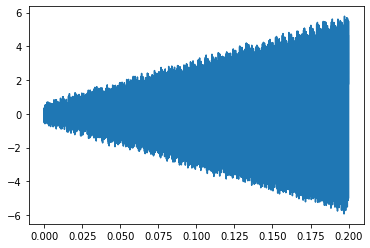

In [9]:
lmin = min(len(ts), len(dds_signal))
plt.plot(ts[:lmin], no_dds-dds_signal[:lmin])
#lmin = min(len(tsp), len(pwm_signal))
#plt.plot(tsp[:lmin], pwm_signal[:lmin])
#lmin = min(len(tsp), len(filtered_signal))
#plt.plot(tsp[:lmin], filtered_signal[:lmin])

83886.00428313666
83886.08000000002
SNR: 34.47152223388818


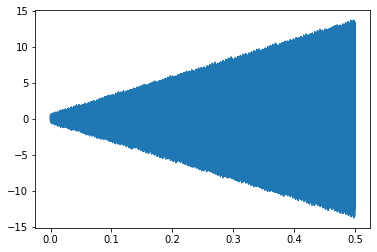

In [10]:
periods_in_max_time = round(0.02*freq)
total_time = 0.5
ts, ys = dds_gen_output_2(note_number, sampling_frequency, total_time)
no_dds = amplitude * np.sin(2*np.pi*freq * (ts)) * 2**(sample_bits-1)
signal_power = np.sum(no_dds**2)/len(no_dds)
print(signal_power)
print((2**(sample_bits-1)*amplitude)**2/2)
dds_error = ys - no_dds
plt.plot(ts, dds_error)
print("SNR:", 10 * np.log10(signal_power/(np.sum(dds_error**2)/len(ts))))

In [11]:
print(10*np.log10(get_dds_snr(80)))

Calculating SNR of note 80
48.30549031196789


In [12]:
(ftws[2]/2**phase_bits)*clock_frequency - note_number_to_freq(2)

-0.003496637456496643